In [ ]:
# https://www.kaggle.com/datasets/datasnaek/mbti-type
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

df = pd.read_csv('/content/mbti_1.csv')

In [ ]:
df = df[['type', 'posts']].copy()
df['posts'] = df['posts'].str.replace('|||', ' ', regex=False)

# Filter to most common types (optional: reduce to top 8 classes)
top_types = df['type'].value_counts().index[:8]
df = df[df['type'].isin(top_types)].reset_index(drop=True)

# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['type'])

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# --- Tokenization and Padding ---
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['posts'])
X_seq = tokenizer.texts_to_sequences(df['posts'])
X_pad = pad_sequences(X_seq, padding='post')
vocab_size = len(tokenizer.word_index) + 1
max_len = X_pad.shape[1]

# --- Label Encoding ---
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['type'])

# --- Triplet Generation ---
def create_triplets(X, y, num_triplets=20000):
    label_to_indices = {}
    for idx, label in enumerate(y):
        label_to_indices.setdefault(label, []).append(idx)

    triplets = []
    for _ in range(num_triplets):
        anchor_label = np.random.choice(list(label_to_indices.keys()))
        anchor_idx = np.random.choice(label_to_indices[anchor_label])
        positive_idx = np.random.choice([i for i in label_to_indices[anchor_label] if i != anchor_idx])
        negative_label = np.random.choice([l for l in label_to_indices.keys() if l != anchor_label])
        negative_idx = np.random.choice(label_to_indices[negative_label])
        triplets.append((anchor_idx, positive_idx, negative_idx))

    return np.array(triplets)

triplets = create_triplets(X_pad, labels)
anchor_input = X_pad[triplets[:, 0]]
positive_input = X_pad[triplets[:, 1]]
negative_input = X_pad[triplets[:, 2]]



In [ ]:
# --- Triplet Loss ---
import tensorflow as tf
from tensorflow.keras import layers, Model

def triplet_loss(margin=0.5):
    def _loss(y_true, y_pred):
        anchor, positive, negative = tf.split(y_pred, 3, axis=1)
        pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
        neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
        return tf.reduce_mean(tf.maximum(pos_dist - neg_dist + margin, 0.0))
    return _loss

# --- Encoder Model ---
# --- Encoder Model ---
import tensorflow as tf
from tensorflow.keras import layers, Model

def build_encoder(vocab_size, max_len, embedding_dim=64):
    inp = layers.Input(shape=(max_len,))
    x = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inp)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(3)(x)
    # Wrap tf.nn.l2_normalize in a Lambda layer
    x = layers.Lambda(lambda x: tf.nn.l2_normalize(x, axis=1))(x) # This line is changed to wrap the TensorFlow function within a Keras Lambda layer
    return Model(inputs=inp, outputs=x, name="mbti_sphere_encoder")

encoder = build_encoder(vocab_size, max_len)

encoder = build_encoder(vocab_size, max_len)

# --- Triplet Training Model ---
anchor_in = layers.Input(shape=(max_len,), name="anchor")
positive_in = layers.Input(shape=(max_len,), name="positive")
negative_in = layers.Input(shape=(max_len,), name="negative")

encoded_anchor = encoder(anchor_in)
encoded_positive = encoder(positive_in)
encoded_negative = encoder(negative_in)

merged = layers.Concatenate(axis=1)([encoded_anchor, encoded_positive, encoded_negative])
triplet_model = Model(inputs=[anchor_in, positive_in, negative_in], outputs=merged)
triplet_model.compile(optimizer='adam', loss=triplet_loss())

# --- Train Model ---
triplet_model.fit(
    [anchor_input, positive_input, negative_input],
    np.zeros(len(anchor_input)),
    batch_size=128,
    epochs=5,
    verbose=1
)

# --- Generate Sphere Embeddings ---
X_embed_sphere_mbti = encoder.predict(X_pad)



Epoch 1/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 113s 696ms/step - loss: 0.4978
Epoch 2/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 109s 696ms/step - loss: 0.4954
Epoch 3/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 109s 696ms/step - loss: 0.4988
Epoch 4/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 141s 688ms/step - loss: 0.4638
Epoch 5/5
157/157 ━━━━━━━━━━━━━━━━━━━━ 142s 689ms/step - loss: 0.3123
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


In [ ]:
np.save('/content/drive/My Drive/X_embed_sphere_mbti.npy', X_embed_sphere_mbti)

In [ ]:
# prompt: np.save('/content/drive/My Drive/X_embed_sphere_mbti.npy', X_embed_sphere_mbti) call this npy file in varible

import numpy as np

X_embed_sphere_mbti = np.load('/content/drive/My Drive/X_embed_sphere_mbti.npy')


In [ ]:
X_embed = X_embed_sphere_mbti

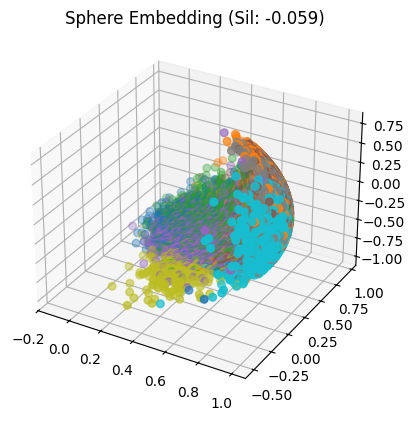

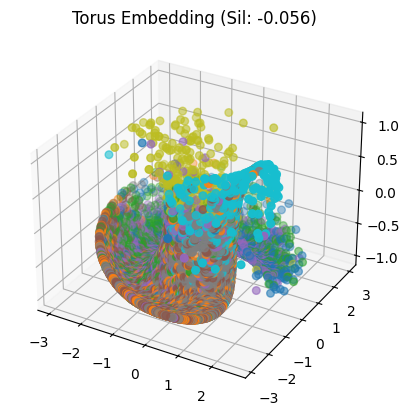

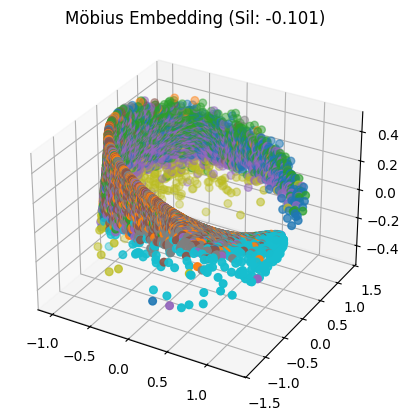

In [ ]:
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

normed = (X_embed - X_embed.mean(0)) / X_embed.std(0)

# Torus
# Use np.ptp() instead of .ptp()
theta = 2 * np.pi * (normed[:, 0] - normed[:, 0].min()) / (np.ptp(normed[:, 0]) + 1e-8)
phi = 2 * np.pi * (normed[:, 1] - normed[:, 1].min()) / (np.ptp(normed[:, 1]) + 1e-8)
r, R = 1.0, 2.0
x_t = (R + r * np.cos(phi)) * np.cos(theta)
y_t = (R + r * np.cos(phi)) * np.sin(theta)
z_t = r * np.sin(phi)
torus = np.vstack([x_t, y_t, z_t]).T
sil_torus = silhouette_score(torus, labels)

# Möbius
# Use np.ptp() instead of .ptp()
theta_m = 2 * np.pi * (normed[:, 0] - normed[:, 0].min()) / (np.ptp(normed[:, 0]) + 1e-8)
w = (normed[:, 1] - normed[:, 1].min()) / (np.ptp(normed[:, 1]) + 1e-8) - 0.5
x_m = (1 + w * np.cos(theta_m / 2)) * np.cos(theta_m)
y_m = (1 + w * np.cos(theta_m / 2)) * np.sin(theta_m)
z_m = w * np.sin(theta_m / 2)
mobius = np.vstack([x_m, y_m, z_m]).T
sil_mobius = silhouette_score(mobius, labels)

# Silhouette of sphere
sil_sphere = silhouette_score(X_embed, labels)

# Plot
def plot_3d(data, title):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels, cmap='tab10', s=30)
    ax.set_title(title)
    plt.show()

plot_3d(X_embed, f"Sphere Embedding (Sil: {sil_sphere:.3f})")
plot_3d(torus, f"Torus Embedding (Sil: {sil_torus:.3f})")
plot_3d(mobius, f"Möbius Embedding (Sil: {sil_mobius:.3f})")

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

def evaluate_models(X_embed, name):
    X_train, X_test, y_train, y_test = train_test_split(X_embed, labels, test_size=0.2, random_state=42)

    log_model = LogisticRegression(max_iter=1000).fit(X_train, y_train)
    rf_model = RandomForestClassifier().fit(X_train, y_train)
    nb_model = GaussianNB().fit(X_train, y_train)

    acc_log = accuracy_score(y_test, log_model.predict(X_test))
    acc_rf = accuracy_score(y_test, rf_model.predict(X_test))
    acc_nb = accuracy_score(y_test, nb_model.predict(X_test))

    return [
        (name, "Logistic Regression", acc_log),
        (name, "Random Forest", acc_rf),
        (name, "Naive Bayes", acc_nb)
    ]

# Evaluate each embedding type
results = []
results += evaluate_models(X_embed, "Sphere")
results += evaluate_models(torus, "Torus")
results += evaluate_models(mobius, "Mobius")

# Display results
results_df = pd.DataFrame(results, columns=["Embedding Type", "Model", "Accuracy"])
print(results_df)


  Embedding Type                Model  Accuracy
0         Sphere  Logistic Regression  0.467058
1         Sphere        Random Forest  0.409654
2         Sphere          Naive Bayes  0.467058
3          Torus  Logistic Regression  0.442922
4          Torus        Random Forest  0.403783
5          Torus          Naive Bayes  0.444879
6         Mobius  Logistic Regression  0.454664
7         Mobius        Random Forest  0.401174
8         Mobius          Naive Bayes  0.448141


Epoch 1/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 20s 312ms/step - loss: 0.1211
Epoch 2/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 279ms/step - loss: 0.0830
Epoch 3/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 18s 295ms/step - loss: 0.0829
Epoch 4/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 19s 276ms/step - loss: 0.0828
Epoch 5/5
60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 285ms/step - loss: 0.0828
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Silhouette Score (Keras Embedding): -0.058


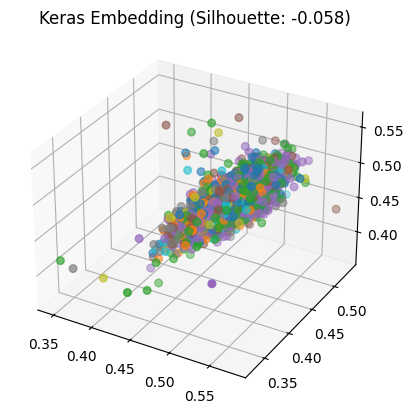

In [ ]:
# STEP 1: Define Encoder
from tensorflow.keras.models import Model
from tensorflow.keras import layers, Input

def build_keras_embedding_encoder(vocab_size, max_len, embedding_dim=64):
    inp = Input(shape=(max_len,))
    x = layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)(inp)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(3)(x)  # output 3D vector
    return Model(inputs=inp, outputs=x)

keras_encoder = build_keras_embedding_encoder(vocab_size, max_len)
keras_encoder.compile(optimizer='adam', loss='mse')

# STEP 2: Dummy Train
import numpy as np
dummy_targets = np.random.rand(X_pad.shape[0], 3)
keras_encoder.fit(X_pad, dummy_targets, epochs=5, batch_size=128)

# STEP 3: Extract Embeddings
X_embed_keras = keras_encoder.predict(X_pad)

# STEP 4: Silhouette Score
from sklearn.metrics import silhouette_score
sil_keras = silhouette_score(X_embed_keras, labels)
print(f"Silhouette Score (Keras Embedding): {sil_keras:.3f}")

# STEP 5: 3D Plot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_embed_keras[:, 0], X_embed_keras[:, 1], X_embed_keras[:, 2], c=labels, cmap='tab10', s=30)
ax.set_title(f"Keras Embedding (Silhouette: {sil_keras:.3f})")
plt.show()



In [ ]:
# STEP 6: Classification Benchmarks
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X_embed_keras, labels, test_size=0.2, random_state=42)

clf_log = LogisticRegression(max_iter=1000).fit(X_train, y_train)
clf_rf = RandomForestClassifier().fit(X_train, y_train)
clf_nb = GaussianNB().fit(X_train, y_train)

acc_log = accuracy_score(y_test, clf_log.predict(X_test))
acc_rf = accuracy_score(y_test, clf_rf.predict(X_test))
acc_nb = accuracy_score(y_test, clf_nb.predict(X_test))

print("\nClassification Accuracy (Keras Embedding):")
print(f"Logistic Regression: {acc_log:.4f}")
print(f"Random Forest:       {acc_rf:.4f}")
print(f"Naive Bayes:         {acc_nb:.4f}")



Classification Accuracy (Keras Embedding):
Logistic Regression: 0.2361
Random Forest:       0.1898
Naive Bayes:         0.2290


In [ ]:
!pip install --upgrade numpy
!pip install --upgrade gensim --no-cache-dir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 52.6 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 229.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 225.7 MB/s eta 0:00:00
   ━━━━━━━━━━

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, silhouette_score
import matplotlib.pyplot as plt
import re

# --- TF-IDF Embedding ---
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(df['posts']).toarray()
X_tfidf_3d = PCA(n_components=3).fit_transform(X_tfidf)
sil_tfidf = silhouette_score(X_tfidf_3d, labels)

# Classifier
X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(X_tfidf, labels, test_size=0.2, random_state=42)
clf_log_tf = LogisticRegression(max_iter=1000).fit(X_train_tf, y_train_tf)
clf_rf_tf = RandomForestClassifier().fit(X_train_tf, y_train_tf)
clf_nb_tf = GaussianNB().fit(X_train_tf, y_train_tf)
acc_log_tf = accuracy_score(y_test_tf, clf_log_tf.predict(X_test_tf))
acc_rf_tf = accuracy_score(y_test_tf, clf_rf_tf.predict(X_test_tf))
acc_nb_tf = accuracy_score(y_test_tf, clf_nb_tf.predict(X_test_tf))

# --- Word2Vec Embedding ---
tokenized = df['posts'].str.lower().str.replace(r'[^a-z0-9\s]', '', regex=True).apply(lambda x: x.split())
w2v_model = Word2Vec(sentences=tokenized, vector_size=100, window=5, min_count=1, workers=4, seed=42)

def avg_word2vec(text):
    words = re.sub(r'[^a-z0-9\s]', '', text.lower()).split()
    vecs = [w2v_model.wv[word] for word in words if word in w2v_model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(w2v_model.vector_size)

X_w2v = np.vstack([avg_word2vec(t) for t in df['posts']])
X_w2v_3d = PCA(n_components=3).fit_transform(X_w2v)
sil_w2v = silhouette_score(X_w2v_3d, labels)

# Classifier
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, labels, test_size=0.2, random_state=42)
clf_log_w2v = LogisticRegression(max_iter=1000).fit(X_train_w2v, y_train_w2v)
clf_rf_w2v = RandomForestClassifier().fit(X_train_w2v, y_train_w2v)
clf_nb_w2v = GaussianNB().fit(X_train_w2v, y_train_w2v)
acc_log_w2v = accuracy_score(y_test_w2v, clf_log_w2v.predict(X_test_w2v))
acc_rf_w2v = accuracy_score(y_test_w2v, clf_rf_w2v.predict(X_test_w2v))
acc_nb_w2v = accuracy_score(y_test_w2v, clf_nb_w2v.predict(X_test_w2v))

# --- Results Table ---
results_phase3 = pd.DataFrame({
    "Embedding Type": ["TF-IDF"] * 3 + ["Word2Vec"] * 3,
    "Model": ["Logistic Regression", "Random Forest", "Naive Bayes"] * 2,
    "Accuracy": [acc_log_tf, acc_rf_tf, acc_nb_tf, acc_log_w2v, acc_rf_w2v, acc_nb_w2v]
})

silhouette_phase3 = pd.DataFrame({
    "Embedding Type": ["TF-IDF", "Word2Vec"],
    "Silhouette Score": [sil_tfidf, sil_w2v]
})



NameError: name 'df' is not defined

In [ ]:
results_phase3

In [ ]:
silhouette_phase3